<a href="https://colab.research.google.com/github/Amar8769/Quantum-Computing/blob/main/ShorsAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit qiskit-aer pylatexenc

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFTGate
from qiskit_aer import AerSimulator
from matplotlib import pyplot

from fractions import Fraction
import random
import sympy
import math



In [ ]:
class CtrlMultCircuit(QuantumCircuit):
    def __init__(self, a, binary_power, N):
        super().__init__(N.bit_length())
        self.a = a
        self.power = 2 ** binary_power
        self.N = N
        self.name = f'{self.a}^{self.power} mod {self.N}'
        self._create_circuit()

    def _create_circuit(self):
        for dec_power in range(self.power):
            a_exp = self.a ** dec_power % self.N
            for i in range(self.num_qubits):
                if a_exp >> i & 1: self.x(i)
                for j in range(i + 1, self.num_qubits):
                    if a_exp >> j & 1: self.swap(i, j)



In [ ]:
class QPECircuit(QuantumCircuit):
    def __init__(self, a, N):
        super().__init__(2 * N.bit_length(), N.bit_length())
        self.a = a
        self.N = N
        self._create_circuit()

    def _modular_exponentiation(self):
        for qbit_idx in range(self.num_qubits // 2):
            self.append(
                CtrlMultCircuit(self.a, qbit_idx, self.N).to_gate().control(),
                [qbit_idx] + list(range(self.num_qubits // 2, 2 * self.num_qubits // 2))
            )

    def _create_circuit(self):
        self.h(range(self.num_qubits // 2))
        self.x(self.num_qubits - 1)
        self.barrier()

        self._modular_exponentiation()
        self.barrier()
        self.append(
            QFTGate(self.num_qubits // 2).inverse(),
            range(self.num_qubits // 2)
        )

    def collapse(self, simulator):
        self.measure(range(self.num_qubits // 2), range(self.num_qubits // 2))
        transpiled_circuit = transpile(self, simulator)
        self.collapse_result = simulator.run(transpiled_circuit, memory=True).result()
        return self.collapse_result



In [ ]:
class ShorAlgorithm:
    def __init__(self, N, max_attempts=-1, random_coprime_only=False, simulator=AerSimulator()):
        self.N = N
        self.simulator = simulator
        self.max_attempts = max_attempts
        self.random_coprime_only = random_coprime_only

        self.qpe_circuit = None

    def execute(self):
        is_N_invalid = self._is_N_invalid()
        if is_N_invalid: return is_N_invalid

        a_values = [a for a in range(2, self.N) if not self.random_coprime_only or (math.gcd(a, self.N) == 1)]
        print(f'[INFO] {len(a_values)} possible values of a: {a_values}')
        self.max_attempts = len(a_values) if self.max_attempts <= -1 else min(self.max_attempts, len(a_values))
        attempts_count = 0

        while attempts_count < self.max_attempts:
            print(f'\n===== Attempt {attempts_count + 1}/{self.max_attempts} =====')
            attempts_count += 1
            self.chosen_a = random.choice(a_values)
            self.r = 1

            print(f'[START] Chosen base a: {self.chosen_a}')
            if not self.random_coprime_only:
                gcd = math.gcd(self.chosen_a, self.N)
                if gcd != 1:
                    print(f'=> {self.chosen_a} and {self.N} share common factor: {self.N} = {gcd} * {self.N // gcd}')
                    return gcd, self.N // gcd

            print(f'>>> {self.chosen_a} and {self.N} are coprime => Perform Quantum Phase Estimation to find {self.chosen_a}^r - 1 = 0 (MOD {self.N})')
            if not self._quantum_period_finding():
                a_values.remove(self.chosen_a)
                continue

            factors = self._classical_postprocess()
            if factors:
                return factors

            a_values.remove(self.chosen_a)

        print(f'[FAIL] No non-trivial factors found after {self.max_attempts} attempts.')


    def _is_N_invalid(self):
        if self.N <= 3:
            print('[ERR] N must be > 3')
            return 1, self.N

        if self.N % 2 == 0:
            print(f'=> {self.N} is an even number: {self.N} = 2 * {self.N // 2}')
            return 2, self.N // 2

        if sympy.isprime(self.N):
            print(f'=> {self.N} is a prime number: {self.N} = 1 * {self.N}')
            return 1, self.N

        max_exponent = int(math.log2(self.N))
        for k in range(max_exponent, 1, -1):
            p = round(self.N ** (1 / k))
            if p ** k == self.N:
                print(f'=> {self.N} is a power of prime: {self.N} = {p}^{k}')
                return p, k
        return False


    def _quantum_period_finding(self):
        while self.chosen_a ** self.r % self.N != 1:
            self.qpe_circuit = QPECircuit(self.chosen_a, self.N)
            result = self.qpe_circuit.collapse(self.simulator)
            state_bin = result.get_memory()[0]
            state_dec = int(state_bin, 2)
            bits_count = 2 ** (self.N.bit_length() - 1)
            phase = state_dec / bits_count


            self.r = Fraction(phase).limit_denominator(self.N).denominator
            if self.r > self.N or self.r == 1:
                print(f'[ERR] Invalid period found: r = {self.r} => Retry with different a.')
                return False

        print(f'>>> Output State: |{state_bin}⟩ = {state_dec} (dec) => Phase = {state_dec} / {bits_count} = {phase:.3f}')
        return True


    def _classical_postprocess(self):

        print(f'>>> Found r = {self.r} => a^{{r/2}} ± 1 = {self.chosen_a:.0f}^{self.r/2:.0f} ± 1')

        if self.r % 2 != 0:
            print(f'[ERR] r = {self.r} is odd => Retry with different a.')
            return None

        int1, int2 = self.chosen_a ** (self.r // 2) - 1, self.chosen_a ** (self.r // 2) + 1
        if int1 % self.N == 0 or int2 % self.N == 0:
            print(f'[ERR] {self.chosen_a}^{self.r/2:.0f} ± 1 is a multiple of {self.N} => Retry with different a.')
            return None

        factor1, factor2 = math.gcd(int1, self.N), math.gcd(int2, self.N)
        if factor1 not in [1, self.N] and factor2 not in [1, self.N]:
            print(f'[DONE] Successfully found non-trivial factors: {self.N} = {factor1} * {factor2}')
            return factor1, factor2

        print(f'[FAIL] Trivial factors found: [1, {self.N}] => Retry with different a.')
        return None


number_to_factor = 55
max_attempts = -1
random_coprime_only = False

shor = ShorAlgorithm(number_to_factor)
factors = shor.execute()


# pyplot.show()

[INFO] 53 possible values of a: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]

===== Attempt 1/53 =====
[START] Chosen base a: 32
>>> 32 and 55 are coprime => Perform Quantum Phase Estimation to find 32^r - 1 = 0 (MOD 55)
>>> Output State: |100011⟩ = 35 (dec) => Phase = 35 / 32 = 1.094
>>> Found r = 32 => a^{r/2} ± 1 = 32^16 ± 1
[ERR] 32^16 ± 1 is a multiple of 55 => Retry with different a.

===== Attempt 2/53 =====
[START] Chosen base a: 46
>>> 46 and 55 are coprime => Perform Quantum Phase Estimation to find 46^r - 1 = 0 (MOD 55)
[ERR] Invalid period found: r = 1 => Retry with different a.

===== Attempt 3/53 =====
[START] Chosen base a: 48
>>> 48 and 55 are coprime => Perform Quantum Phase Estimation to find 48^r - 1 = 0 (MOD 55)
[ERR] Invalid period found: r = 1 => Retry with different a.

===== Attempt 4/53 =====
[START] Cho

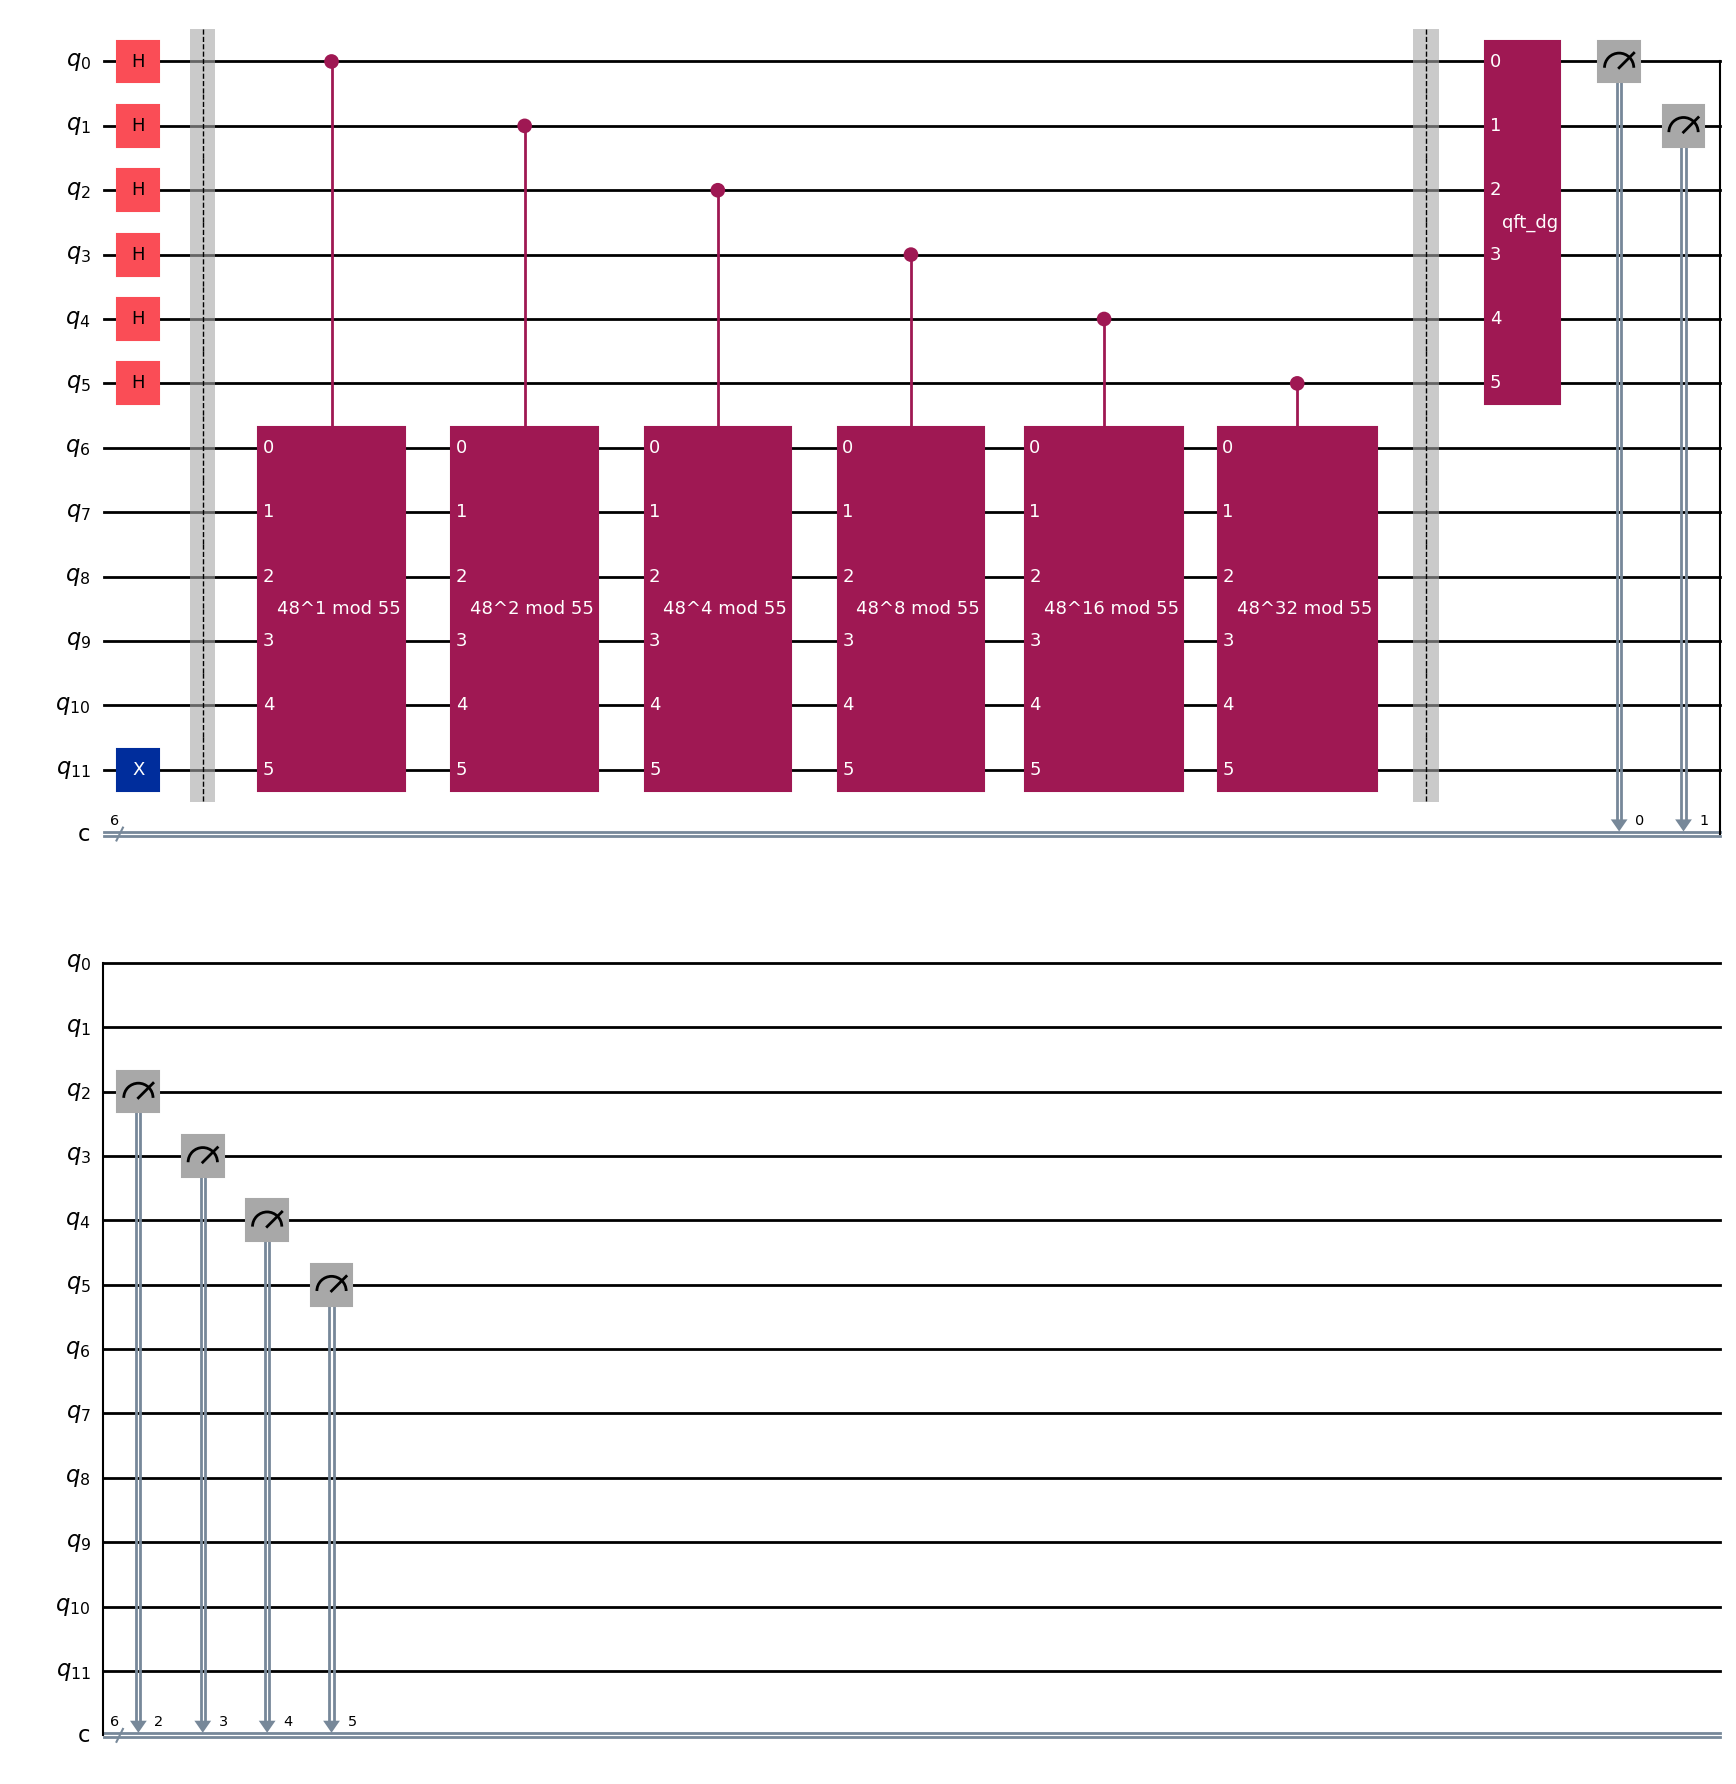

In [ ]:
shor.qpe_circuit.draw('mpl')